<a href="https://colab.research.google.com/github/niest-pc/Ejercicios-Ciencia_de_Datos/blob/main/03_clasificacionBinaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación Binaria
Capítulo 3 del libro **The Data Science Workshop.** *Second Edition* (2020). Packt Publishing.

En este capítulo trata sobre la clasificación binaria mediante regresión logística desde la perspectiva de resolver un caso de uso.
- Se presentan problemas de clasificación, específicamente los problemas de clasificación binaria.
- Se analiza el problema de clasificación desde la perspectiva de predecir la propensión a los depósitos a plazo mediante un proceso de descubrimiento de negocio. En este proceso, se identifican diferentes impulsores de negocio que influyen en los resultados.
- Las intuiciones derivadas del análisis exploratorio se utilizan para crear nuevas características a partir de las variables sin procesar.
- Se construye un modelo de regresión logística de referencia y se analizan las métricas para identificar un plan de acción futuro. Posteriormente, se itera sobre el modelo de referencia creando un segundo modelo que incorpora las variables diseñadas para las características.

El conjunto de datos que se utiliza en este capítulo es un conjunto de datos bancarios de S. Moro, P. Cortez y P. Rita: ***A Data-Driven Approach to Predict the Success of Bank Telemarketing***.


## Introducción

### Ejercicio 3.01: Carga y exploración de los datos del conjunto de datos
En este ejercicio se carga el conjunto de datos y se realizan algunas exploraciones básicas, como imprimir las dimensiones del conjunto de datos y generar estadísticas de resumen del conjunto de datos.



In [ ]:
# Importando pandas
import pandas as pd

# Url del archivo con los datos
url_archivo = 'https://raw.githubusercontent.com/PacktWorkshops/'\
'The-Data-Science-Workshop/master/Chapter03/bank-full.csv'

# Cargando los datos
datosBanco = pd.read_csv(url_archivo, sep=";")

# Visualizando las primeras filas
datosBanco.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
# Obteniendo el tamaño del conjunto de datos
print(datosBanco.shape)

# Obteniendo el resumen de los datos numéricos
datosBanco.describe()

(45211, 17)


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Ejercicio 3.02: Prueba de hipótesis empresarial para la edad frente a la propensión a un préstamo a plazo
El objetivo de este ejercicio es definir una hipótesis para comprobar la propensión de una persona a adquirir un plan de depósito a plazo en función de su edad.

In [ ]:
# Importando librería altair
import altair as alt

# Filtrando los casos donde el depósito a plazo es sí
filtro = datosBanco['y'] == 'yes'

# Agrupando por edad y contando el número de registros para cada grupo
bancoSub1 = datosBanco[filtro].groupby('age')['y'].agg(agegrp = 'count').reset_index()

# Trazando un gráfico de líneas usando altair
alt.Chart(bancoSub1).mark_line().encode(x = 'age', y = 'agegrp').properties(width = 495,
                                                                            height = 330)

alt.Chart(...)

In [ ]:
# Agrupando los datos por edad y encontrando el número total de clientes en cada grupo de edad.
totalEdad = datosBanco.groupby('age')['y'].agg(ageTot='count').reset_index()

totalEdad.tail(10)

,age,ageTot
67,85,5
68,86,9
69,87,4
70,88,2
71,89,3
72,90,2
73,92,2
74,93,2
75,94,1
76,95,2


In [ ]:
# Agrupando los datos por edad y propensión a los depósitos a plazo
propensionEdad = datosBanco.groupby(['age','y'])['y'].agg(ageCat='count').reset_index()

propensionEdad.tail(10)

,age,y,ageCat
138,87,no,1
139,87,yes,3
140,88,no,2
141,89,no,3
142,90,yes,2
143,92,yes,2
144,93,yes,2
145,94,no,1
146,95,no,1
147,95,yes,1


In [ ]:
# Combinando los DataFrames anteriores según la edad
combinacionEdad = pd.merge(propensionEdad[:140], totalEdad[:70],
                           left_on = ['age'], right_on = ['age'])

# Dividiendo cada categoría de propensión dentro de cada grupo de edad entre el
# total de clientes en el respectivo grupo para obtener la proporción de clientes
combinacionEdad['catProp'] = (combinacionEdad.ageCat/combinacionEdad.ageTot)*100

combinacionEdad.tail(10)

,age,y,ageCat,ageTot,catProp
130,83,no,16,22,72.727273
131,83,yes,6,22,27.272727
132,84,no,4,9,44.444444
133,84,yes,5,9,55.555556
134,85,no,1,5,20.000000
135,85,yes,4,5,80.000000
136,86,no,5,9,55.555556
137,86,yes,4,9,44.444444
138,87,no,1,4,25.000000
139,87,yes,3,4,75.000000


In [ ]:
# Mostrando la proporción donde se representan ambas categorías (sí y no)
alt.Chart(combinacionEdad).mark_line().encode(x = 'age',
                                              y = 'catProp').facet(column = 'y')

alt.FacetChart(...)

### Actividad 3.01: Prueba de hipótesis empresarial para determinar la situación laboral frente a la propensión a adquirir depósitos a plazo fijo
Trabajas como científico de datos en un banco. Recibes datos históricos de la gerencia del banco y se te pide que intentes formular una hipótesis sobre la relación entre la situación laboral y la propensión a adquirir depósitos a plazo fijo.

In [ ]:
# Agrupando los datos por situación laboral
# y encontrando el número total de clientes en cada grupo.
totalTrabajo = datosBanco.groupby('job')['y'].agg(ageTot='count').reset_index()

# Mostrando las primeras filas
totalTrabajo.head()

,job,ageTot
0,admin.,5171
1,blue-collar,9732
2,entrepreneur,1487
3,housemaid,1240
4,management,9458


In [ ]:
# Agrupando los datos por situación laboral y propensión a los depósitos a plazo
propensionTrabajo = datosBanco.groupby(['job','y'])['y'].agg(ageCat='count').reset_index()

# Mostrando las primeras filas
propensionTrabajo.head()

,job,y,ageCat
0,admin.,no,4540
1,admin.,yes,631
2,blue-collar,no,9024
3,blue-collar,yes,708
4,entrepreneur,no,1364


In [ ]:
# Combinando los DataFrames anteriores según la situación laboral
combinacionTrabajo = pd.merge(propensionTrabajo, totalTrabajo,
                           left_on = ['job'], right_on = ['job'])

# Dividiendo cada categoría de propensión dentro de cada grupo entre el
# total de clientes en el respectivo grupo para obtener la proporción de clientes
combinacionTrabajo['catProp'] = (combinacionTrabajo.ageCat/combinacionTrabajo.ageTot)*100

# Mostrando las primeras filas
combinacionTrabajo = combinacionTrabajo.sort_values(by = ['y', 'catProp'], ascending = False)
combinacionTrabajo

,job,y,ageCat,ageTot,catProp
17,student,yes,269,938,28.678038
11,retired,yes,516,2264,22.791519
21,unemployed,yes,202,1303,15.502686
9,management,yes,1301,9458,13.755551
1,admin.,yes,631,5171,12.202669
13,self-employed,yes,187,1579,11.842939
23,unknown,yes,34,288,11.805556
19,technician,yes,840,7597,11.056996
15,services,yes,369,4154,8.883004
7,housemaid,yes,109,1240,8.790323


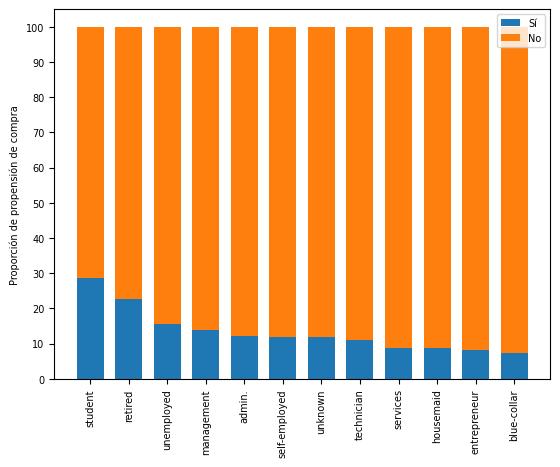

In [ ]:
# importando librerias
import matplotlib.pyplot as plt
import numpy as np

# Obteniendo los datos según la propensión a los depósitos a plazo
combinacionTrabajoSi = combinacionTrabajo[combinacionTrabajo['y'] == 'yes']
combinacionTrabajoNo = combinacionTrabajo[combinacionTrabajo['y'] == 'no']

# Obteniendo el número de etiquetas del eje x y organizando sus indices
etiquetasx = combinacionTrabajo['job'].nunique()
indices = np.arange(etiquetasx)

# Obteniendo la proporción de los valores
trabajoSi = combinacionTrabajoSi['catProp'].unique()
trabajoNo = combinacionTrabajoNo['catProp'].unique()

# Realizando las gráficas
p1 = plt.bar(indices, trabajoSi, 0.7)
p2 = plt.bar(indices, sorted(trabajoNo, reverse = False), 0.7, bottom = trabajoSi)

# Agregando etiquetas y definiendo los indices en los ejes
plt.ylabel('Proporción de propensión de compra')
plt.xticks(indices, combinacionTrabajo['job'].unique())
plt.yticks(np.arange(0, 101, 10))

# Agregando leyenda
plt.legend((p1[0], p2[0]), ('Sí', 'No'))

# Rotando las etiquetas del eje x
plt.xticks(rotation = 90)

# Mostrando la gráfica
plt.show()

## Ingeniería de características

### Ejercicio 3.03: Ingeniería de Características – Exploración de Características Individuales
En este ejercicio se explora la relación entre dos variables, a saber, si una persona posee una vivienda y si tiene un préstamo, y su propensión a comprar depósitos a plazo fijo.

In [ ]:
# Encontrando una relación entre la vivienda y la propensión a los depósitos a plazo.
totalVivienda = datosBanco.groupby(['housing'])['y'].agg(houseTot =
                                                         'count').reset_index()
propensionVivienda = datosBanco.groupby(['housing',
                                         'y'])['y'].agg(houseCat =
                                                        'count').reset_index()
combinacionVivienda = pd.merge(propensionVivienda, totalVivienda,
                           left_on = ['housing'], right_on = ['housing'])

combinacionVivienda['prop'] = np.round((combinacionVivienda.houseCat/
                                       combinacionVivienda.houseTot)*100, 2)

combinacionVivienda

,housing,y,houseCat,houseTot,prop
0,no,no,16727,20081,83.3
1,no,yes,3354,20081,16.7
2,yes,no,23195,25130,92.3
3,yes,yes,1935,25130,7.7


In [ ]:
# Encontrando la relación entre tener un préstamo y la propensión a los
# depósitos a plazo
totalPrestamo = datosBanco.groupby(['loan'])['y'].agg(loanTot =
                                                      'count').reset_index()
propensionPrestamo = datosBanco.groupby(['loan',
                                         'y'])['y'].agg(loanCat =
                                                        'count').reset_index()
combinacionPrestamo = pd.merge(propensionPrestamo, totalPrestamo,
                           left_on = ['loan'], right_on = ['loan'])

combinacionPrestamo['prop'] = np.round((combinacionPrestamo.loanCat/
                                       combinacionPrestamo.loanTot)*100, 2)

combinacionPrestamo

,loan,y,loanCat,loanTot,prop
0,no,no,33162,37967,87.34
1,no,yes,4805,37967,12.66
2,yes,no,6760,7244,93.32
3,yes,yes,484,7244,6.68


In [ ]:
# Calculando los cuantiles para los datos de saldo bancario
datosBanco['balance'].quantile([0.25, 0.5, 0.75])

,balance
0.25,72.0
0.50,448.0
0.75,1428.0


In [ ]:
# Convirtiendo los valores numéricos de los saldos bancarios en valores categóricos
# Se crea una función llamada balanceClass para almacenar las categorías de cuantiles
# Se establece su valor predeterminado en Quan1. Posteriormente, según cada umbral de valor,
# los puntos de datos se clasifican en la clase de cuantiles correspondiente.
datosBanco['balanceClass'] = 'Quant1'
datosBanco.loc[(datosBanco['balance'] > 72) &
 (datosBanco['balance'] < 448), 'balanceClass'] = 'Quant2'
datosBanco.loc[(datosBanco['balance'] > 448) &
 (datosBanco['balance'] < 1428), 'balanceClass'] = 'Quant3'
datosBanco.loc[datosBanco['balance'] > 1428, 'balanceClass'] = 'Quant4'
datosBanco.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,balanceClass
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,Quant4
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,Quant1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,Quant1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,Quant4
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,Quant1


In [ ]:
# Calculando número de clientes bajo cada cuantil
totalSaldo = datosBanco.groupby(['balanceClass'])['y'].agg(balanceTotal =
                                                           'count').reset_index()
totalSaldo

,balanceClass,balanceTotal
0,Quant1,11340
1,Quant2,11275
2,Quant3,11299
3,Quant4,11297


In [ ]:
# Calculando el número total de clientes categorizados por cuantil y propensión.
propensionSaldo = datosBanco.groupby(['balanceClass',
                                  'y'])['y'].agg(balanceCat =
                                                 'count').reset_index()
propensionSaldo

,balanceClass,y,balanceCat
0,Quant1,no,10517
1,Quant1,yes,823
2,Quant2,no,10049
3,Quant2,yes,1226
4,Quant3,no,9884
5,Quant3,yes,1415
6,Quant4,no,9472
7,Quant4,yes,1825


In [ ]:
# Fusionando los dos dataframes anteriores
combinacionSaldo = pd.merge(propensionSaldo, totalSaldo, on = ['balanceClass'])

# Obteniendo la proporción por categoria
combinacionSaldo['catProp'] = np.round((combinacionSaldo.balanceCat/
                                       combinacionSaldo.balanceTotal)*100, 2)

combinacionSaldo

,balanceClass,y,balanceCat,balanceTotal,catProp
0,Quant1,no,10517,11340,92.74
1,Quant1,yes,823,11340,7.26
2,Quant2,no,10049,11275,89.13
3,Quant2,yes,1226,11275,10.87
4,Quant3,no,9884,11299,87.48
5,Quant3,yes,1415,11299,12.52
6,Quant4,no,9472,11297,83.85
7,Quant4,yes,1825,11297,16.15


### Ejercicio 3.04: Ingeniería de Características: Creación de Nuevas Características a partir de las Existentes
En este ejercicio se combinan las variables individuales analizadas en el Ejercicio 3.03 para obtener una nueva característica denominada índice de activos. Una metodología para crear un índice de activos consiste en asignar ponderaciones basadas en el activo o pasivo del cliente.

Por ejemplo, un mayor saldo bancario o la propiedad de una vivienda tendrán un impacto positivo en el índice general de activos y, por lo tanto, se les asignará una mayor ponderación. Por el contrario, la presencia de un préstamo será un pasivo y, por lo tanto, deberá tener una ponderación menor.

Se asigna una ponderación de 5 si el cliente tiene una vivienda y 1 si no la tiene. De igual forma, se asigna una ponderación de 1 si el cliente tiene un préstamo y 5 si no tiene.

In [ ]:
# Importando paquetes
from sklearn import preprocessing

# Conviertiendo datos a decimales
x = datosBanco[['balance']].values.astype(float)

# Convirtiendo los datos numéricos en un rango de escala de 0 a 1.
minmaxScaler = preprocessing.MinMaxScaler()

# Transformando los datos de saldo normalizándolos
datosBanco['balanceTran'] = minmaxScaler.fit_transform(x)

# Mostrando las primeras filas
datosBanco.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,balanceClass,balanceTran
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,Quant4,0.092259
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,Quant1,0.073067
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,Quant1,0.072822
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,Quant4,0.086476
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,Quant1,0.072812


In [ ]:
# Sumando un valor de 0.001 para eliminar los valores 0 en la variable
datosBanco['balanceTran'] = datosBanco['balanceTran'] + 0.00001

In [ ]:
# Agregando dos columnas adicionales para introducir las variables transformadas
# para préstamos y vivienda, según el enfoque de ponderación discutido en el enunciado
datosBanco['houseTran'] = 5
datosBanco.loc[datosBanco['housing'] == 'no', 'houseTran'] = 1
datosBanco['loanTran'] = 1
datosBanco.loc[datosBanco['loan'] == 'no', 'loanTran'] = 5
datosBanco.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,y,balanceClass,balanceTran,houseTran,loanTran
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,261,1,-1,0,unknown,no,Quant4,0.092269,5,5
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,151,1,-1,0,unknown,no,Quant1,0.073077,5,5
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,76,1,-1,0,unknown,no,Quant1,0.072832,5,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,92,1,-1,0,unknown,no,Quant4,0.086486,5,5
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,198,1,-1,0,unknown,no,Quant1,0.072822,1,5


In [ ]:
# Creando una nueva variable, que es el producto de todas las variables transformadas
datosBanco['assetIndex'] = datosBanco['balanceTran'] * datosBanco['houseTran'] * datosBanco['loanTran']
datosBanco.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,y,balanceClass,balanceTran,houseTran,loanTran,assetIndex
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,1,-1,0,unknown,no,Quant4,0.092269,5,5,2.306734
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,1,-1,0,unknown,no,Quant1,0.073077,5,5,1.826916
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,1,-1,0,unknown,no,Quant1,0.072832,5,1,0.364158
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,1,-1,0,unknown,no,Quant4,0.086486,5,5,2.162153
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,1,-1,0,unknown,no,Quant1,0.072822,1,5,0.364112


In [ ]:
# Encontrando los cuantiles
datosBanco['assetIndex'].quantile([0.25, 0.5, 0.75])

,assetIndex
0.25,0.376686
0.50,0.569204
0.75,1.902725


In [ ]:
# Creando cuantiles a partir de los datos de "assetIndex"
datosBanco['assetClass'] = 'Quant1'
datosBanco.loc[(datosBanco['assetIndex'] > 0.377) & (datosBanco['assetIndex'] < 0.569), 'assetClass'] = 'Quant2'
datosBanco.loc[(datosBanco['assetIndex'] > 0.569) & (datosBanco['assetIndex'] < 1.9), 'assetClass'] = 'Quant3'
datosBanco.loc[datosBanco['assetIndex'] > 1.9, 'assetClass'] = 'Quant4'
datosBanco.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,pdays,previous,poutcome,y,balanceClass,balanceTran,houseTran,loanTran,assetIndex,assetClass
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,-1,0,unknown,no,Quant4,0.092269,5,5,2.306734,Quant4
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,-1,0,unknown,no,Quant1,0.073077,5,5,1.826916,Quant3
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,-1,0,unknown,no,Quant1,0.072832,5,1,0.364158,Quant1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,-1,0,unknown,no,Quant4,0.086486,5,5,2.162153,Quant4
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,-1,0,unknown,no,Quant1,0.072822,1,5,0.364112,Quant1


In [ ]:
# Calculando el total de cada clase de activo
totalActivo = datosBanco.groupby('assetClass')['y'].agg(assetTot =
                                                     'count').reset_index()
# Calculando los recuentos por categoría
propensionActivo = datosBanco.groupby(['assetClass', 'y'])['y'].agg(assetCat =
                                                             'count').reset_index()

# Fusionando ambos dataframes
combinacionActivo = pd.merge(propensionActivo, totalActivo, on = ['assetClass'])
combinacionActivo['catProp'] = np.round((combinacionActivo.assetCat/
                                       combinacionActivo.assetTot)*100, 2)
combinacionActivo

,assetClass,y,assetCat,assetTot,catProp
0,Quant1,no,10231,11379,89.91
1,Quant1,yes,1148,11379,10.09
2,Quant2,no,9117,11224,81.23
3,Quant2,yes,2107,11224,18.77
4,Quant3,no,10153,11130,91.22
5,Quant3,yes,977,11130,8.78
6,Quant4,no,10421,11478,90.79
7,Quant4,yes,1057,11478,9.21


## Matriz de correlación y visualización

### Ejercicio 3.05: Encontrando la correlación en los datos para generar un gráfico de correlación utilizando datos bancarios
En este ejercicio se crea un gráfico de correlación y se analizan los resultados del conjunto de datos bancarios.

In [ ]:
# Creando variable que almacenará las variables numéricas
datosNumericos = datosBanco[['age','balance','day','duration',
                             'campaign','pdays','previous']]

# Calculando la matriz de correlación para el conjunto de datos:
correlacionN = datosNumericos.corr(method = 'pearson')
correlacionN

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


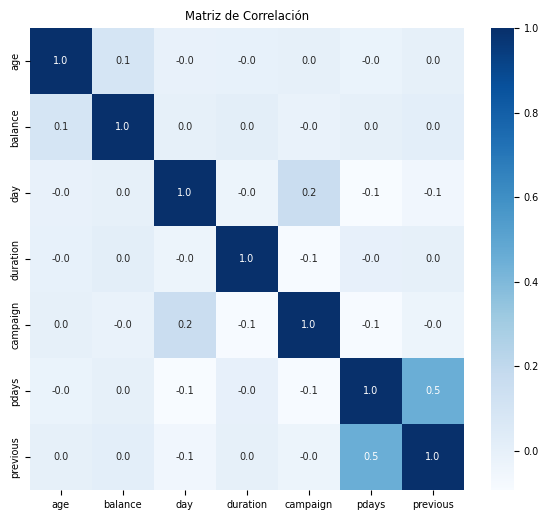

In [ ]:
# Graficando la matriz de correlacion
import seaborn as sns
plt.rcParams.update({'font.size': 7})
plt.figure(figsize=(7, 6))  # Ajusta el tamaño del gráfico
sns.heatmap(correlacionN, annot=True, cmap="Blues", fmt=".1f")
plt.title("Matriz de Correlación")
plt.show()

### Ejercicio 3.06: Modelo de regresión logística para predecir la propensión a las compras de depósitos a plazo en un banco
En este ejercicio se construye un modelo de regresión logística para predecir la propensión a las compras de depósitos a plazo. Este ejercicio consta de tres partes: la primera consiste en el preprocesamiento de los datos, la segunda en el proceso de entrenamiento y la última en la predicción, el análisis de métricas y la formulación de estrategias para la mejora del modelo.

In [ ]:
# Cargando las funciones y datos de librerías
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
# Obteniendo los tipos de datos de las variables
datosBanco.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [ ]:
# Convirtiendo datos ordinales en datos ficticios
catBanco = pd.get_dummies(datosBanco[['job', 'marital', 'education', 'default',
                                      'housing', 'loan', 'contact', 'month',
                                      'poutcome']])
catBanco.shape

(45211, 44)

In [ ]:
# Separando las variables numéricas
numBanco = datosBanco[['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
                       'previous']]
numBanco.shape

(45211, 7)

In [ ]:
# Preparando las variables independientes
X = pd.concat([catBanco, numBanco], axis=1)
print(X.shape)

# Preparando la variable dependiente
Y = datosBanco['y']
print(Y.shape)

X.head()

(45211, 51)
(45211,)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,False,False,False,False,True,False,False,False,False,False,...,False,False,True,58,2143,5,261,1,-1,0
1,False,False,False,False,False,False,False,False,False,True,...,False,False,True,44,29,5,151,1,-1,0
2,False,False,True,False,False,False,False,False,False,False,...,False,False,True,33,2,5,76,1,-1,0
3,False,True,False,False,False,False,False,False,False,False,...,False,False,True,47,1506,5,92,1,-1,0
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,33,1,5,198,1,-1,0


In [ ]:
# Dividiendo los datos en conjuntos de entrenamiento y prueba
entrenamientoX, pruebaX, entrenamientoY, pruebaY = train_test_split(X, Y, test_size = 0.3,
                                                                    random_state = 123)

# Llamando a la función de regresión logística
modeloBanco = LogisticRegression()

# Ajustando el modelo con los datos del conjunto de entrenamiento
modeloBanco.fit(entrenamientoX, entrenamientoY)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Usando el modelo para predecir los conjuntos de prueba
predicciones = modeloBanco.predict(pruebaX)

# Obteniendo el nivel de precisión de las predicciones
print('Precisión de la predicción del modelo de regresión logística '\
      'en el conjunto de prueba: {:.2f}'.format(modeloBanco.score(pruebaX,
                                                                  pruebaY)))

Precisión de la predicción del modelo de regresión logística en el conjunto de prueba: 0.89


In [ ]:
# Matriz de confusión para el modelo
from sklearn.metrics import confusion_matrix
matrizConf = confusion_matrix(pruebaY, predicciones)
print(matrizConf)

[[11754   244]
 [ 1242   324]]


In [ ]:
# Generando un reporte de clasificación
from sklearn.metrics import classification_report
print(classification_report(pruebaY, predicciones))

              precision    recall  f1-score   support

          no       0.90      0.98      0.94     11998
         yes       0.57      0.21      0.30      1566

    accuracy                           0.89     13564
   macro avg       0.74      0.59      0.62     13564
weighted avg       0.87      0.89      0.87     13564



### Actividad 3.02: Iteración de Modelo 2 – Modelo de Regresión Logística con Variables de Ingeniería de Características
En el _Ejercicio 3.06_ se creó un modelo de referencia para predecir qué clientes probablemente adquirirán un depósito a plazo. Sin embargo, la gerencia desea mejorar los resultados obtenidos en el modelo de referencia. En el _Ejercicio 3.04_ se creó una nueva variable, **assetIndex**, mediante la ingeniería de características de tres variables sin procesar. Ahora se ajusta otro modelo de regresión logística a las variables de ingeniería de características intentando mejorar los resultados.




In [ ]:
# Creando variables ficticias para las variables categóricas
catBanco2 = pd.get_dummies(datosBanco[['job', 'marital', 'education', 'default',
                                      'contact', 'month', 'poutcome']])
catBanco2.shape

(45211, 40)

In [ ]:
# Seleccionando las variables numéricas
numBanco1 = datosBanco[['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
                       'previous', 'assetIndex']]
numBanco1.shape

(45211, 8)

In [ ]:
# Creando las variables de transformación
ageT1 = numBanco1[['age']].values.astype(float)
dayT1 = numBanco1[['day']].values.astype(float)
durationT1 = numBanco1[['duration']].values.astype(float)

# Normalizando los datos
pd.options.mode.chained_assignment = None
numBanco1['ageTran'] = minmaxScaler.fit_transform(ageT1)
numBanco1['dayTran'] = minmaxScaler.fit_transform(dayT1)
numBanco1['durationTran'] = minmaxScaler.fit_transform(durationT1)

# Creando una nueva variable numérica con las variables transformadas
numBanco2 = numBanco1[['ageTran','dayTran','durationTran', 'campaign', 'pdays',
                       'previous', 'assetIndex']]
numBanco2.head()

,ageTran,dayTran,durationTran,campaign,pdays,previous,assetIndex
0,0.519481,0.133333,0.053070,1,-1,0,2.306734
1,0.337662,0.133333,0.030704,1,-1,0,1.826916
2,0.194805,0.133333,0.015453,1,-1,0,0.364158
3,0.376623,0.133333,0.018707,1,-1,0,2.162153
4,0.194805,0.133333,0.040260,1,-1,0,0.364112


In [ ]:
# Preparando las variables independientes
X2 = pd.concat([catBanco2, numBanco1], axis=1)
print(X2.shape)

# Preparando la variable dependiente
Y2 = datosBanco['y']
print(Y2.shape)

X2.head()

(45211, 51)
(45211,)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,balance,day,duration,campaign,pdays,previous,assetIndex,ageTran,dayTran,durationTran
0,False,False,False,False,True,False,False,False,False,False,...,2143,5,261,1,-1,0,2.306734,0.519481,0.133333,0.053070
1,False,False,False,False,False,False,False,False,False,True,...,29,5,151,1,-1,0,1.826916,0.337662,0.133333,0.030704
2,False,False,True,False,False,False,False,False,False,False,...,2,5,76,1,-1,0,0.364158,0.194805,0.133333,0.015453
3,False,True,False,False,False,False,False,False,False,False,...,1506,5,92,1,-1,0,2.162153,0.376623,0.133333,0.018707
4,False,False,False,False,False,False,False,False,False,False,...,1,5,198,1,-1,0,0.364112,0.194805,0.133333,0.040260


In [ ]:
# Dividiendo los datos en conjuntos de entrenamiento y prueba
entrenamientoX2, pruebaX2, entrenamientoY2, pruebaY2 = train_test_split(X2, Y2,
                                                                        test_size = 0.3,
                                                                        random_state = 123)

# Llamando a la función de regresión logística
modeloBanco2 = LogisticRegression()

# Ajustando el modelo con los datos del conjunto de entrenamiento
modeloBanco2.fit(entrenamientoX2, entrenamientoY2)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Usando el modelo para predecir los conjuntos de prueba
predicciones2 = modeloBanco2.predict(pruebaX2)

# Obteniendo el nivel de precisión de las predicciones
print('Precisión de la predicción del modelo de regresión logística '\
      'en el conjunto de prueba: {:.2f}'.format(modeloBanco2.score(pruebaX2,
                                                                  pruebaY2)))

Precisión de la predicción del modelo de regresión logística en el conjunto de prueba: 0.89


In [ ]:
# Matriz de confusión para el modelo
matrizConf2 = confusion_matrix(pruebaY2, predicciones2)
print(matrizConf2)

[[11766   232]
 [ 1269   297]]


In [ ]:
# Generando un reporte de clasificación
print(classification_report(pruebaY2, predicciones2))


              precision    recall  f1-score   support

          no       0.90      0.98      0.94     11998
         yes       0.56      0.19      0.28      1566

    accuracy                           0.89     13564
   macro avg       0.73      0.59      0.61     13564
weighted avg       0.86      0.89      0.86     13564

